In [2]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import metrics
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold,GroupKFold
from sklearn.metrics import roc_auc_score
sns.set()
%matplotlib inline

import os
from glob import glob
import feather
import os
os.chdir('../src')
import gc
import sys
import warnings
warnings.filterwarnings('ignore')
from copy import deepcopy

plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams['font.family'] = 'Ricty Diminised'
sns.set(style="whitegrid", font='Ricty Diminised', palette="muted",
        color_codes=True, rc={'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

import japanize_matplotlib

import EDA
import make_data
import matplotlib.dates as mdates

/Users/yuki.matsumoto/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
#各種設定
pd.set_option('display.max_columns',100)

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
def kesson_table(df):
    null_val = df.isnull().sum()
    percent = 100 * df.isnull().sum()/len(df)
    kesson_table = pd.concat([null_val,percent],axis=1)
    kesson_table_ren_columns = kesson_table.rename(columns = {0:'lack num',1:'%'})
    return kesson_table_ren_columns

In [6]:
def kesson_table_cut_low_percent(df):
    null_val = df.isnull().sum()
    percent = 100 * df.isnull().sum()/len(df)
    
    kesson_table = pd.concat([null_val,percent],axis=1)
    kesson_table_ren_columns = kesson_table.rename(columns = {0:'lack num',1:'%'})
    kesson_table_ren_columns = kesson_table_ren_columns[kesson_table_cut_low_percent["%"]<90]
    return kesson_table_ren_columns

In [15]:
df_DAU = pd.read_csv('../jn/input/DiDi/Didi_Twitter_PeformanceBranding_SDKData_DAU.csv')

In [8]:
df_DAU.head(6)

,campaign,2019年10月28日,2019年10月29日,2019年10月30日,2019年10月31日,2019年11月1日,2019年11月2日,2019年11月3日,2019年11月4日,2019年11月5日,2019年11月6日,2019年11月7日,2019年11月8日,2019年11月9日,2019年11月10日,2019年11月13日,2019年11月14日,2019年11月15日,2019年11月17日,2019年11月18日,2019年11月20日,2019年11月21日,2019年11月22日,2019年11月23日,2019年11月24日,2019年11月25日,2019年11月26日,2019年11月27日,2019年11月28日,2019年11月29日,2019年11月30日,2019年12月1日,2019年12月2日,2019年12月3日,2019年12月4日,2019年12月5日,2019年12月6日,2019年12月7日,2019年12月8日,2019年12月9日,2019年12月10日,2019年12月11日,2019年12月12日,2019年12月13日,2019年12月14日,2019年12月15日,2019年12月16日,2019年12月17日,2019年12月18日,2019年12月19日,2019年12月20日,2019年12月21日,2019年12月22日,2019年12月23日,2019年12月24日,2019年12月25日,2019年12月26日,2019年12月27日,2019年12月28日,2019年12月29日,2019年12月30日,2019年12月31日,2020年1月1日,2020年1月2日,2020年1月3日,2020年1月4日,2020年1月5日,2020年1月6日,2020年1月7日,2020年1月8日,2020年1月9日,2020年1月10日,2020年1月11日,2020年1月12日,2020年1月13日,2020年1月14日,2020年1月15日,2020年1月16日,2020年1月17日
0,hakuhodody_DiDi_appinstall_Android_KDDIユーザー,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,1.0,2.0,1.0,NaN,1.0,1.0,1.0,2.0,1.0,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0
1,hakuhodody_DiDi_appinstall_Android_ビジネス関心_KDDI...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_SB_D...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_タクシー...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_ビジネス...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,1.0,2.0,NaN,1.0,NaN,1.0,3.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,3.0,1.0,2.0,1.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0
5,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_子育て_...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
def make_fulldata(save=True):
    # load sales
    root = '../jn/input/DiDi/'

    df_DAU = pd.read_csv(root + 'Didi_Twitter_PeformanceBranding_SDKData_DAU.csv')
    df_MAU = pd.read_csv(root + 'Didi_Twitter_PeformanceBranding_SDKData_MAU.csv')
    df_install = pd.read_csv(root + 'Didi_Twitter_PeformanceBranding_SDKData_install.csv')
    
    # cleansing string to numerical
#     df['sales_amt'] = df['sales_amt'].apply(lambda x: x.replace(',', '')).astype(int)
#     df['num_regi_customer'] = df['num_regi_customer'].apply(lambda x: x.replace(',', '')).astype(int)
#     df['seg_code'] = df['seg_code'].apply(lambda x: x.replace(',', ''))
    
#     # date time preprocessing
#     train_df['timestamp'] = pd.to_datetime(train_df['timestamp'], format='%Y-%m-%d %H:%M:%S')
#     test_df['timestamp'] = pd.to_datetime(test_df['timestamp'], format='%Y-%m-%d %H:%M:%S')
    
#     df['year']  = df['date'].dt.year
#     df['month'] = df['date'].dt.month
#     df['day']   = df['date'].dt.day
#     df['dow']   = df['date'].dt.dayofweek

   
    # merge data
#     df = df.merge(shop.drop(columns=['bland_code', 'pref_code', 'date']), on='seg_code', how='left')
    
    if save:
        df_DAU.to_pickle(f'../jn/input/pickle/df_DAU.pkl')
        df_MAU.to_pickle(f'../jn/input/pickle/df_MAU.pkl')
        df_install.to_pickle(f'../jn/input/pickle/df_install.pkl')
    
    return df_DAU,df_MAU,df_install

In [18]:
df_DAU,df_MAU,df_install = make_fulldata(save=True)

In [19]:
df_DAU = make_data.reduce_mem_usage(df_DAU)
df_MAU = make_data.reduce_mem_usage(df_MAU)
df_install = make_data.reduce_mem_usage(df_install)

Mem. usage decreased to  0.01 Mb (49.2% reduction)
Mem. usage decreased to  0.00 Mb (42.4% reduction)
Mem. usage decreased to  0.01 Mb (47.0% reduction)


In [20]:
print(f'cohorts_df dataset has {df_DAU.shape[0]} rows and {df_DAU.shape[1]} columns.')
print(f'map_df dataset has {df_MAU.shape[0]} rows and {df_MAU.shape[1]} columns.')
print(f'map_df dataset has {df_install.shape[0]} rows and {df_install.shape[1]} columns.')

cohorts_df dataset has 33 rows and 79 columns.
map_df dataset has 33 rows and 5 columns.
map_df dataset has 35 rows and 38 columns.


## DAU

In [14]:
display(df_DAU.head(100))
display(df_DAU.shape)

,campaign,2019年10月28日,2019年10月29日,2019年10月30日,2019年10月31日,2019年11月1日,2019年11月2日,2019年11月3日,2019年11月4日,2019年11月5日,...,2020年1月8日,2020年1月9日,2020年1月10日,2020年1月11日,2020年1月12日,2020年1月13日,2020年1月14日,2020年1月15日,2020年1月16日,2020年1月17日
0,hakuhodody_DiDi_appinstall_Android_KDDIユーザー,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0
1,hakuhodody_DiDi_appinstall_Android_ビジネス関心_KDDI...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_SB_D...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_タクシー...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_ビジネス...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0
5,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_子育て_...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_若手起業...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_政治_S...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_通院介護...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
9,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_投資金融...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(33, 79)

In [57]:
df_DAU_KDDI = df_DAU[df_DAU['campaign'].str.contains('KDDI|campaign')]
df_DAU_SD = df_DAU[df_DAU['campaign'].str.contains('SB_DCM|campaign')]

In [58]:
df_DAU_KDDI = df_DAU_KDDI.T
df_DAU_SD = df_DAU_SD.T

In [59]:
df_DAU_KDDI_sum = pd.DataFrame(df_DAU_KDDI.sum(axis=1))
df_DAU_KDDI_sum = df_DAU_KDDI_sum.reset_index()
df_DAU_KDDI_sum

,index,0
0,campaign,hakuhodody_DiDi_appinstall_Android_KDDIユーザーhak...
1,2019年10月28日,0
2,2019年10月29日,0
3,2019年10月30日,1
4,2019年10月31日,0
5,2019年11月1日,1
6,2019年11月2日,2
7,2019年11月3日,1
8,2019年11月4日,1
9,2019年11月5日,0


In [60]:
df_DAU_SD_sum = pd.DataFrame(df_DAU_SD.sum(axis=1))
df_DAU_SD_sum = df_DAU_SD_sum.reset_index()
df_DAU_SD_sum

,index,0
0,campaign,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_SB_D...
1,2019年10月28日,4
2,2019年10月29日,4
3,2019年10月30日,4
4,2019年10月31日,3
5,2019年11月1日,3
6,2019年11月2日,3
7,2019年11月3日,1
8,2019年11月4日,0
9,2019年11月5日,1


In [61]:
df_DAU_KDDI_sum_list = df_DAU_KDDI_sum[df_DAU_KDDI_sum['index']=='campaign'].values.tolist()
df_DAU_SD_sum_list = df_DAU_SD_sum[df_DAU_SD_sum['index']=='campaign'].values.tolist()

In [62]:
# 2行目以降を別のdfにしとく
df_DAU_KDDI_sum=df_DAU_KDDI_sum[1:]
# ちぎったdfのcolumnを設定
df_DAU_KDDI_sum.columns = df_DAU_KDDI_sum_list
df_DAU_KDDI_sum.columns = ["campaign","KDDI_sum"]
df_DAU_KDDI_sum.to_csv('../jn/output/df_DAU_KDDI_sum.csv')

# 2行目以降を別のdfにしとく
df_DAU_SD_sum=df_DAU_SD_sum[1:]
# ちぎったdfのcolumnを設定
df_DAU_SD_sum.columns = df_DAU_SD_sum_list
df_DAU_SD_sum.columns = ["campaign","SD_sum"]
df_DAU_SD_sum.to_csv('../jn/output/df_DAU_SD_sum.csv')

In [63]:
df_DAU_KDDI_sum

,campaign,KDDI_sum
1,2019年10月28日,0
2,2019年10月29日,0
3,2019年10月30日,1
4,2019年10月31日,0
5,2019年11月1日,1
6,2019年11月2日,2
7,2019年11月3日,1
8,2019年11月4日,1
9,2019年11月5日,0
10,2019年11月6日,2


In [64]:
df_DAU_SD_sum

,campaign,SD_sum
1,2019年10月28日,4
2,2019年10月29日,4
3,2019年10月30日,4
4,2019年10月31日,3
5,2019年11月1日,3
6,2019年11月2日,3
7,2019年11月3日,1
8,2019年11月4日,0
9,2019年11月5日,1
10,2019年11月6日,0


In [65]:
DAU_df = df_DAU_SD_sum.merge(df_DAU_KDDI_sum, on='campaign')
DAU_df["campaign"] = pd.to_datetime(DAU_df["campaign"],format='%Y-%m-%d')
DAU_df

ValueError: time data 2019年10月28日 doesn't match format specified

In [66]:
df_DAU_KDDI_sum["campaign"] = pd.to_datetime(df_DAU_KDDI_sum["campaign"],format='%Y年%m月%d日')
df_DAU_SD_sum["campaign"] = pd.to_datetime(df_DAU_SD_sum["campaign"],format='%Y年%m月%d日')

Text(0.5, 1.0, 'DAU')

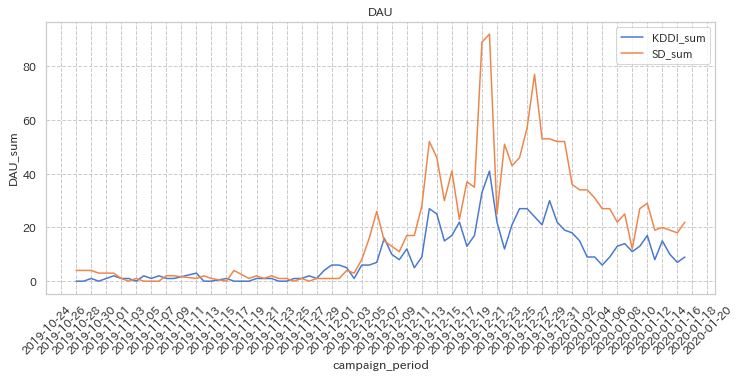

In [67]:
fig, ax = plt.subplots(figsize=(12, 5))

days = mdates.DayLocator(bymonthday=None, interval=2, tz=None)
months = mdates.MonthLocator(bymonth=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]) # 月の設定
years = mdates.YearLocator() # 年の設定
majorFmt = mdates.DateFormatter('%Y-%m-%d') # おっきい軸用フォーマット

plt.plot(df_DAU_KDDI_sum["campaign"],df_DAU_KDDI_sum["KDDI_sum"])
plt.plot(df_DAU_SD_sum["campaign"],df_DAU_SD_sum["SD_sum"])

ax.grid(True)
ax.grid(which='minor', linestyle=':')
ax.xaxis.set_major_formatter(majorFmt)
ax.xaxis.set_major_locator(days) # なくても良い（統一感なくて気持ち悪かったので書いた）
ax.xaxis.set_minor_locator(days)
plt.xticks(rotation=45); # 上に同じく 
plt.xlabel("campaign_period")
plt.ylabel("DAU_sum")
plt.legend()

plt.title('DAU')

## MAU

In [207]:
df_MAU = pd.read_csv('../jn/input/DiDi/Didi_Twitter_PeformanceBranding_SDKData_MAU.csv')
df_MAU.head(100)

,campaign,2019年10月,2019年11月,2019年12月,2020年1月
0,hakuhodody_DiDi_appinstall_Android_KDDIユーザー,NaN,3.0,6,2.0
1,hakuhodody_DiDi_appinstall_Android_ビジネス関心_KDDI...,NaN,NaN,1,NaN
2,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_SB_D...,NaN,1.0,2,1.0
3,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_タクシー...,NaN,NaN,2,1.0
4,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_ビジネス...,4.0,2.0,14,6.0
5,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_子育て_...,NaN,NaN,3,NaN
6,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_若手起業...,NaN,NaN,1,NaN
7,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_政治_S...,NaN,NaN,1,NaN
8,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_通院介護...,NaN,NaN,1,2.0
9,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_投資金融...,1.0,1.0,3,2.0


In [211]:
df_MAU_KDDI = df_MAU[df_MAU['campaign'].str.contains('KDDI')]
df_MAU_SD = df_MAU[df_MAU['campaign'].str.contains('SB_DCM')]

,campaign,2019年10月,2019年11月,2019年12月,2020年1月
0,hakuhodody_DiDi_appinstall_Android_KDDIユーザー,NaN,3.0,6,2.0
1,hakuhodody_DiDi_appinstall_Android_ビジネス関心_KDDI...,NaN,NaN,1,NaN
11,hakuhodody_DiDi_appinstall_Android_旅行関心_KDDIユーザー,NaN,NaN,1,NaN
12,hakuhodody_DiDi_appinstall_iOS_KDDIユーザー,1.0,5.0,33,14.0
13,hakuhodody_DiDi_appinstall_iOS_タクシーアプリ関連_KDDIユーザー,NaN,NaN,11,2.0
14,hakuhodody_DiDi_appinstall_iOS_ビジネス関心_KDDIユーザー,NaN,NaN,18,8.0
15,hakuhodody_DiDi_appinstall_iOS_子育て_KDDIユーザー,NaN,NaN,7,2.0
16,hakuhodody_DiDi_appinstall_iOS_若手起業関心_KDDIユーザー,NaN,NaN,18,7.0
17,hakuhodody_DiDi_appinstall_iOS_主婦_KDDIユーザー,NaN,2.0,29,10.0
18,hakuhodody_DiDi_appinstall_iOS_政治_KDDIユーザー,NaN,NaN,15,7.0


KDDI_MAU

In [215]:
df_MAU_KDDI_sum = pd.DataFrame(df_MAU_KDDI.sum())
df_MAU_KDDI_sum = df_MAU_KDDI_sum.reset_index()
df_MAU_KDDI_sum_list = df_MAU_KDDI_sum[df_MAU_KDDI_sum['index']=='campaign'].values.tolist()
# 2行目以降を別のdfにしとく
df_MAU_KDDI_sum = df_MAU_KDDI_sum[1:]
# ちぎったdfのcolumnを設定
df_MAU_KDDI_sum.columns = df_MAU_KDDI_sum_list
df_MAU_KDDI_sum.columns = ["campaign","KDDI_MAU_sum"]
df_MAU_KDDI_sum.to_csv('../jn/output/df_MAU_KDDI_sum.csv')
df_MAU_KDDI_sum

,campaign,KDDI_MAU_sum
1,2019年10月,1
2,2019年11月,13
3,2019年12月,314
4,2020年1月,111


SD_MAU

In [216]:
df_MAU_SD_sum = pd.DataFrame(df_MAU_SD.sum())
df_MAU_SD_sum = df_MAU_SD_sum.reset_index()
df_MAU_SD_sum_list = df_MAU_SD_sum[df_MAU_SD_sum['index']=='campaign'].values.tolist()
# 2行目以降を別のdfにしとく
df_MAU_SD_sum = df_MAU_SD_sum[1:]
# ちぎったdfのcolumnを設定
df_MAU_SD_sum.columns = df_MAU_SD_sum_list
df_MAU_SD_sum.columns = ["campaign","SD_MAU_sum"]
df_MAU_SD_sum.to_csv('../jn/output/df_MAU_SD_sum.csv')
df_MAU_SD_sum

,campaign,SD_MAU_sum
1,2019年10月,8
2,2019年11月,19
3,2019年12月,652
4,2020年1月,245


No handles with labels found to put in legend.


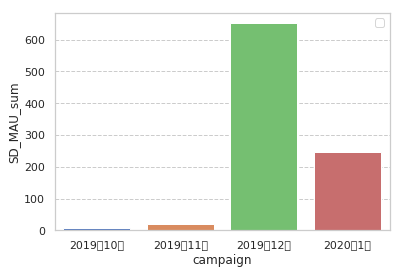

In [228]:
sns.barplot(x="campaign", y="SD_MAU_sum",data=df_MAU_SD_sum)
plt.xlabel("campaign")
plt.ylabel("SD_MAU_sum")
plt.legend()

## Trip

In [31]:
df_Trip = pd.read_csv('../jn/input/DiDi/Didi_Twitter_PeformanceBranding_SDKData_Trip.csv')
df_Trip.head(100)

,campaign,2019/10/28,2019/10/29,2019/10/30,2019/10/31,2019/11/1,2019/11/2,2019/11/3,2019/11/4,2019/11/5,...,2020/1/8,2020/1/9,2020/1/10,2020/1/11,2020/1/12,2020/1/13,2020/1/14,2020/1/15,2020/1/16,2020/1/17
0,hakuhodody_DiDi_appinstall_Android_KDDIユーザー,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0
1,hakuhodody_DiDi_appinstall_Android_ビジネス関心_KDDI...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_SB_D...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_タクシー...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_ビジネス...,1.0,1.0,3.0,1.0,2.0,1.0,1.0,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,2.0,NaN,NaN,1.0
5,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_子育て_...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_若手起業...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_政治_S...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_通院介護...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
9,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_投資金融...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
df_Trip_KDDI = df_Trip[df_Trip['campaign'].str.contains('KDDI')]
df_Trip_SD = df_Trip[df_Trip['campaign'].str.contains('SB_DCM')]

In [33]:
df_Trip_KDDI = df_Trip_KDDI.T
df_Trip_SD = df_Trip_SD.T

In [34]:
df_Trip_KDDI_sum = pd.DataFrame(df_Trip_KDDI.sum(axis=1))
df_Trip_KDDI_sum = df_Trip_KDDI_sum.reset_index()
df_Trip_KDDI_sum_list = df_Trip_KDDI_sum[df_Trip_KDDI_sum['index']=='campaign'].values.tolist()
# 2行目以降を別のdfにしとく
df_Trip_KDDI_sum = df_Trip_KDDI_sum[1:]
# ちぎったdfのcolumnを設定
df_Trip_KDDI_sum.columns = df_Trip_KDDI_sum_list
df_Trip_KDDI_sum.columns = ["campaign","KDDI_Trip_sum"]
df_Trip_KDDI_sum.to_csv('../jn/output/df_Trip_KDDI_sum.csv')
df_Trip_KDDI_sum

,campaign,KDDI_Trip_sum
1,2019/10/28,0
2,2019/10/29,0
3,2019/10/30,0
4,2019/10/31,0
5,2019/11/1,1
6,2019/11/2,2
7,2019/11/3,2
8,2019/11/4,1
9,2019/11/5,0
10,2019/11/6,3


In [35]:
df_Trip_SD_sum = pd.DataFrame(df_Trip_SD.sum(axis=1))
df_Trip_SD_sum = df_Trip_SD_sum.reset_index()
df_Trip_SD_sum_list = df_Trip_SD_sum[df_Trip_SD_sum['index']=='campaign'].values.tolist()
# 2行目以降を別のdfにしとく
df_Trip_SD_sum = df_Trip_SD_sum[1:]
# ちぎったdfのcolumnを設定
df_Trip_SD_sum.columns = df_Trip_SD_sum_list
df_Trip_SD_sum.columns = ["campaign","SD_Trip_sum"]
df_Trip_SD_sum.to_csv('../jn/output/df_Trip_SD_sum.csv')
df_Trip_SD_sum

,campaign,SD_Trip_sum
1,2019/10/28,4
2,2019/10/29,6
3,2019/10/30,4
4,2019/10/31,3
5,2019/11/1,5
6,2019/11/2,4
7,2019/11/3,1
8,2019/11/4,0
9,2019/11/5,1
10,2019/11/6,0


In [36]:
df_Trip_KDDI_sum["campaign"] = pd.to_datetime(df_Trip_KDDI_sum["campaign"],format='%Y/%m/%d')
df_Trip_SD_sum["campaign"] = pd.to_datetime(df_Trip_SD_sum["campaign"],format='%Y/%m/%d')

Text(0.5, 1.0, 'Trip')

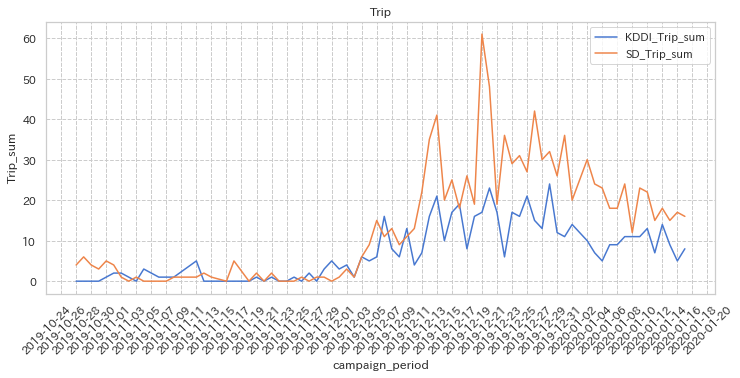

In [37]:
fig, ax = plt.subplots(figsize=(12, 5))

days = mdates.DayLocator(bymonthday=None, interval=2, tz=None)
months = mdates.MonthLocator(bymonth=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]) # 月の設定
years = mdates.YearLocator() # 年の設定
majorFmt = mdates.DateFormatter('%Y-%m-%d') # おっきい軸用フォーマット

plt.plot(df_Trip_KDDI_sum["campaign"],df_Trip_KDDI_sum["KDDI_Trip_sum"])
plt.plot(df_Trip_SD_sum["campaign"],df_Trip_SD_sum["SD_Trip_sum"])


ax.grid(True)
ax.grid(which='minor', linestyle=':')
ax.xaxis.set_major_formatter(majorFmt)
ax.xaxis.set_major_locator(days) # なくても良い（統一感なくて気持ち悪かったので書いた）
ax.xaxis.set_minor_locator(days)
plt.xticks(rotation=45); # 上に同じく 
plt.xlabel("campaign_period")
plt.ylabel("Trip_sum")
plt.legend()

plt.title('Trip')

Text(0.5, 1.0, 'num')

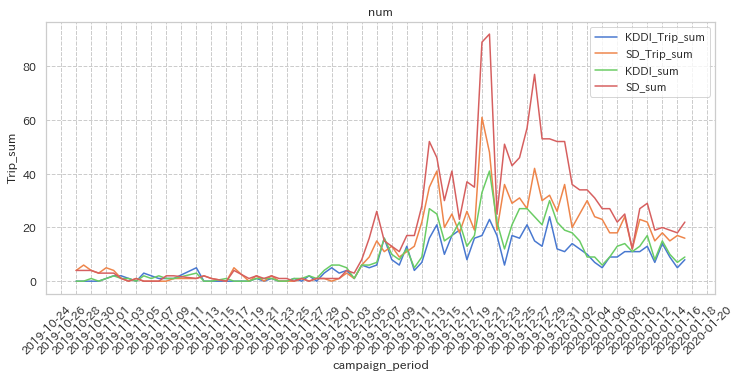

In [38]:
fig, ax = plt.subplots(figsize=(12, 5))

days = mdates.DayLocator(bymonthday=None, interval=2, tz=None)
months = mdates.MonthLocator(bymonth=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]) # 月の設定
years = mdates.YearLocator() # 年の設定
majorFmt = mdates.DateFormatter('%Y-%m-%d') # おっきい軸用フォーマット

plt.plot(df_Trip_KDDI_sum["campaign"],df_Trip_KDDI_sum["KDDI_Trip_sum"])
plt.plot(df_Trip_SD_sum["campaign"],df_Trip_SD_sum["SD_Trip_sum"])

plt.plot(df_DAU_KDDI_sum["campaign"],df_DAU_KDDI_sum["KDDI_sum"])
plt.plot(df_DAU_SD_sum["campaign"],df_DAU_SD_sum["SD_sum"])

ax.grid(True)
ax.grid(which='minor', linestyle=':')
ax.xaxis.set_major_formatter(majorFmt)
ax.xaxis.set_major_locator(days) # なくても良い（統一感なくて気持ち悪かったので書いた）
ax.xaxis.set_minor_locator(days)
plt.xticks(rotation=45); # 上に同じく 
plt.xlabel("campaign_period")
plt.ylabel("Trip_sum")
plt.legend()

plt.title('num')

In [52]:
df_Trip = df_Trip_KDDI_sum.merge(df_Trip_SD_sum, on="campaign")

In [68]:
Trip_df = df_DAU_SD_sum.merge(df_DAU_KDDI_sum, on='campaign')
Trip_df["campaign"] = pd.to_datetime(Trip_df["campaign"],format='%Y-%m-%d')
Trip_df

,campaign,SD_sum,KDDI_sum
0,2019-10-28,4,0
1,2019-10-29,4,0
2,2019-10-30,4,1
3,2019-10-31,3,0
4,2019-11-01,3,1
5,2019-11-02,3,2
6,2019-11-03,1,1
7,2019-11-04,0,1
8,2019-11-05,1,0
9,2019-11-06,0,2


In [74]:
df_DAU_Trip = Trip_df.merge(DAU_df, on="campaign")
df_DAU_Trip.to_csv('../jn/output/df_DAU_Trip.csv')

### PFC

In [29]:
df_PFC= pd.read_csv('../jn/input/DiDi/Didi_Twitter_PeformanceBranding_SDKData_PFC.csv')

In [30]:
df_PFC_KDDI = df_PFC[df_PFC['campaign'].str.contains('KDDI')]
df_PFC_SD = df_PFC[df_PFC['campaign'].str.contains('SB_DCM')]

In [35]:
df_PFC_KDDI = df_PFC_KDDI.T
df_PFC_SD = df_PFC_SD.T

In [50]:
df_PFC_KDDI_sum = pd.DataFrame(df_PFC_KDDI.sum(axis=1))
df_PFC_KDDI_sum = df_PFC_KDDI_sum.reset_index()
df_PFC_KDDI_sum_list = df_PFC_KDDI_sum[df_PFC_KDDI_sum['index']=='campaign'].values.tolist()
# 2行目以降を別のdfにしとく
df_PFC_KDDI_sum = df_PFC_KDDI_sum[2:]
# ちぎったdfのcolumnを設定
df_PFC_KDDI_sum.columns = df_PFC_KDDI_sum_list
df_PFC_KDDI_sum.columns = ["campaign","PFC_KDDI_sum"]
df_PFC_KDDI_sum.to_csv('../jn/output/df_PFC_KDDI_sum.csv')
df_PFC_KDDI_sum = df_PFC_KDDI_sum[0:57]
df_PFC_KDDI_sum["campaign"] = pd.to_datetime(df_PFC_KDDI_sum["campaign"],format='%Y年%m月%d日')

In [52]:
df_PFC_SD_sum = pd.DataFrame(df_PFC_SD.sum(axis=1))
df_PFC_SD_sum = df_PFC_SD_sum.reset_index()
df_PFC_SD_sum_list = df_PFC_SD_sum[df_PFC_SD_sum['index']=='campaign'].values.tolist()
# 2行目以降を別のdfにしとく
df_PFC_SD_sum = df_PFC_SD_sum[2:]
# ちぎったdfのcolumnを設定
df_PFC_SD_sum.columns = df_PFC_SD_sum_list
df_PFC_SD_sum.columns = ["campaign","PFC_SD_sum"]
df_PFC_SD_sum.to_csv('../jn/output/df_PFC_SD_sum.csv')
df_PFC_SD_sum = df_PFC_SD_sum[0:57]
df_PFC_SD_sum["campaign"] = pd.to_datetime(df_PFC_SD_sum["campaign"],format='%Y年%m月%d日')

Text(0.5, 1.0, 'PFC')

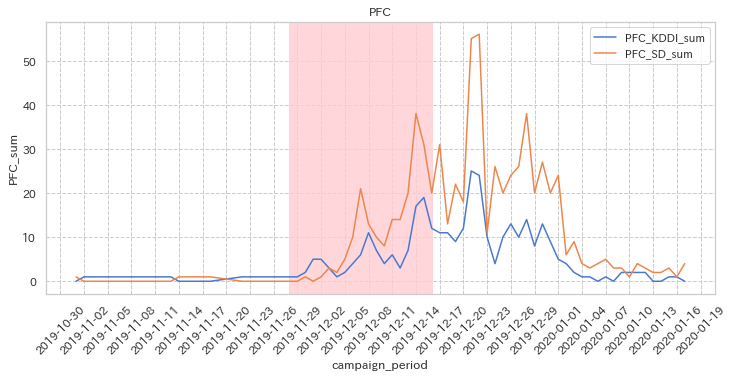

In [69]:
fig, ax = plt.subplots(figsize=(12, 5))

days = mdates.DayLocator(bymonthday=None, interval=3, tz=None)
months = mdates.MonthLocator(bymonth=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]) # 月の設定
years = mdates.YearLocator() # 年の設定
majorFmt = mdates.DateFormatter('%Y-%m-%d') # おっきい軸用フォーマット

plt.plot(df_PFC_KDDI_sum["campaign"],df_PFC_KDDI_sum["PFC_KDDI_sum"])
plt.plot(df_PFC_SD_sum["campaign"],df_PFC_SD_sum["PFC_SD_sum"])

# plt.plot(df_DAU_KDDI_sum["campaign"],df_DAU_KDDI_sum["KDDI_sum"])
# plt.plot(df_DAU_SD_sum["campaign"],df_DAU_SD_sum["SD_sum"])

ax.grid(True)
ax.grid(which='minor', linestyle=':')
ax.xaxis.set_major_formatter(majorFmt)
ax.xaxis.set_major_locator(days) # なくても良い（統一感なくて気持ち悪かったので書いた）
ax.xaxis.set_minor_locator(days)
plt.xticks(rotation=45); # 上に同じく 
plt.xlabel("campaign_period")
plt.ylabel("PFC_sum")
plt.legend()

plt.axvspan('2019-11-28','2019-12-16',alpha=0.8,color="#ffcdd2",label="R/F")

plt.title('PFC')

### Installs

In [184]:
df_Install_KDDI = df_install[df_install['campaign'].str.contains('KDDI')]
df_Install_SD = df_install[df_install['campaign'].str.contains('SB_DCM')]

In [185]:
df_Install_KDDI = df_Install_KDDI.T
df_Install_SD = df_Install_SD.T

In [187]:
df_Ins_KDDI_sum = pd.DataFrame(df_Install_KDDI.sum(axis=1))
df_Ins_KDDI_sum = df_Ins_KDDI_sum.reset_index()
df_Ins_KDDI_sum_list = df_Ins_KDDI_sum[df_Ins_KDDI_sum['index']=='campaign'].values.tolist()
# 2行目以降を別のdfにしとく
df_Ins_KDDI_sum = df_Ins_KDDI_sum[2:]
# ちぎったdfのcolumnを設定
df_Ins_KDDI_sum.columns = df_Ins_KDDI_sum_list
df_Ins_KDDI_sum.columns = ["campaign","Ins_KDDI_sum"]
df_Ins_KDDI_sum.to_csv('../jn/output/df_Ins_KDDI_sum.csv')
df_Ins_KDDI_sum = df_Ins_KDDI_sum[0:57]
df_Ins_KDDI_sum["campaign"] = pd.to_datetime(df_Ins_KDDI_sum["campaign"],format='%Y/%m/%d')

In [188]:
df_Ins_SD_sum = pd.DataFrame(df_Install_SD.sum(axis=1))
df_Ins_SD_sum = df_Ins_SD_sum.reset_index()
df_Ins_SD_sum_list = df_Ins_SD_sum[df_Ins_SD_sum['index']=='campaign'].values.tolist()
# 2行目以降を別のdfにしとく
df_Ins_SD_sum = df_Ins_SD_sum[2:]
# ちぎったdfのcolumnを設定
df_Ins_SD_sum.columns = df_Ins_SD_sum_list
df_Ins_SD_sum.columns = ["campaign","Ins_SD_sum"]
df_Ins_SD_sum.to_csv('../jn/output/df_Ins_SD_sum.csv')
df_Ins_SD_sum = df_Ins_SD_sum[0:57]
df_Ins_SD_sum["campaign"] = pd.to_datetime(df_Ins_SD_sum["campaign"],format='%Y/%m/%d')

In [189]:
df_Ins_SD_sum

,campaign,Ins_SD_sum
2,2019-11-29,1
3,2019-11-30,8
4,2019-12-01,8
5,2019-12-02,9
6,2019-12-03,10
7,2019-12-04,14
8,2019-12-05,35
9,2019-12-06,45
10,2019-12-07,55
11,2019-12-08,41


Text(0.5, 1.0, 'Install')

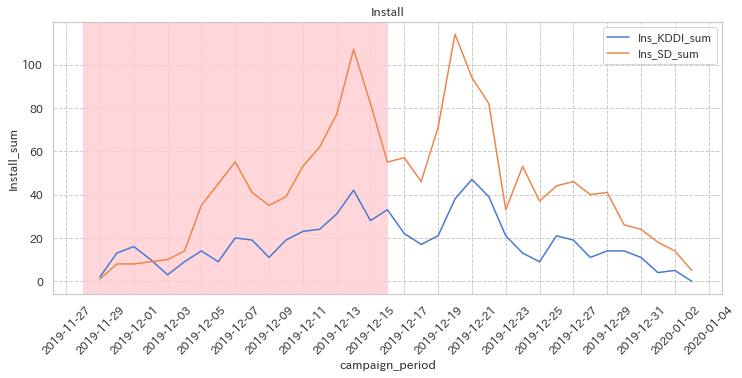

In [299]:
fig, ax = plt.subplots(figsize=(12, 5))

days = mdates.DayLocator(bymonthday=None, interval=2, tz=None)
months = mdates.MonthLocator(bymonth=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]) # 月の設定
years = mdates.YearLocator() # 年の設定
majorFmt = mdates.DateFormatter('%Y-%m-%d') # おっきい軸用フォーマット

plt.plot(df_Ins_KDDI_sum["campaign"],df_Ins_KDDI_sum["Ins_KDDI_sum"])
plt.plot(df_Ins_SD_sum["campaign"],df_Ins_SD_sum["Ins_SD_sum"])

# plt.plot(df_DAU_KDDI_sum["campaign"],df_DAU_KDDI_sum["KDDI_sum"])
# plt.plot(df_DAU_SD_sum["campaign"],df_DAU_SD_sum["SD_sum"])

ax.grid(True)
ax.grid(which='minor', linestyle=':')
ax.xaxis.set_major_formatter(majorFmt)
ax.xaxis.set_major_locator(days) # なくても良い（統一感なくて気持ち悪かったので書いた）
ax.xaxis.set_minor_locator(days)
plt.xticks(rotation=45); # 上に同じく 
plt.xlabel("campaign_period")
plt.ylabel("Install_sum")
plt.legend()

plt.axvspan('2019-11-28','2019-12-16',alpha=0.8,color="#ffcdd2",label="R/F")

plt.title('Install')

### Call

In [159]:
df_Call = pd.read_csv('../jn/input/DiDi/Didi_Twitter_PeformanceBranding_SDKData_Call.csv')

In [160]:
df_Call_KDDI = df_Call[df_Call['campaign'].str.contains('KDDI')]
df_Call_SD = df_Call[df_Call['campaign'].str.contains('SB_DCM')]

In [161]:
df_Call_KDDI = df_Call_KDDI.T
df_Call_SD = df_Call_SD.T

In [171]:
df_Call_KDDI_sum = pd.DataFrame(df_Call_KDDI.sum(axis=1))
df_Call_KDDI_sum = df_Call_KDDI_sum.reset_index()
df_Call_KDDI_sum_list = df_Call_KDDI_sum[df_Call_KDDI_sum['index']=='campaign'].values.tolist()
# 2行目以降を別のdfにしとく
df_Call_KDDI_sum = df_Call_KDDI_sum[2:]
# ちぎったdfのcolumnを設定
df_Call_KDDI_sum.columns = df_Call_KDDI_sum_list
df_Call_KDDI_sum.columns = ["campaign","Call_KDDI_sum"]
df_Call_KDDI_sum.to_csv('../jn/output/df_Call_KDDI_sum.csv')
df_Call_KDDI_sum = df_Call_KDDI_sum[0:78]
df_Call_KDDI_sum["campaign"] = pd.to_datetime(df_Call_KDDI_sum["campaign"],format='%Y/%m/%d')

In [172]:
df_Call_SD_sum = pd.DataFrame(df_Call_SD.sum(axis=1))
df_Call_SD_sum = df_Call_SD_sum.reset_index()
df_Call_SD_sum_list = df_Call_SD_sum[df_Call_SD_sum['index']=='campaign'].values.tolist()
# 2行目以降を別のdfにしとく
df_Call_SD_sum = df_Call_SD_sum[2:]
# ちぎったdfのcolumnを設定
df_Call_SD_sum.columns = df_Call_SD_sum_list
df_Call_SD_sum.columns = ["campaign","Call_SD_sum"]
df_Call_SD_sum.to_csv('../jn/output/df_Call_SD_sum.csv')
df_Call_SD_sum = df_Call_SD_sum[0:78]
df_Call_SD_sum["campaign"] = pd.to_datetime(df_Call_SD_sum["campaign"],format='%Y/%m/%d')

Text(0.5, 1.0, 'Call')

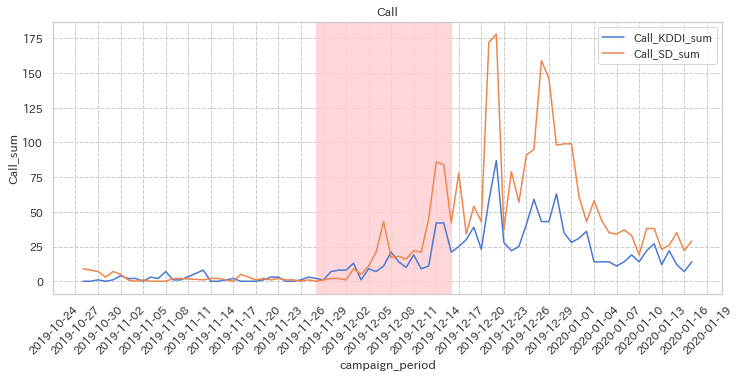

In [174]:
fig, ax = plt.subplots(figsize=(12, 5))

days = mdates.DayLocator(bymonthday=None, interval=3, tz=None)
months = mdates.MonthLocator(bymonth=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]) # 月の設定
years = mdates.YearLocator() # 年の設定
majorFmt = mdates.DateFormatter('%Y-%m-%d') # おっきい軸用フォーマット

plt.plot(df_Call_KDDI_sum["campaign"],df_Call_KDDI_sum["Call_KDDI_sum"])
plt.plot(df_Call_SD_sum["campaign"],df_Call_SD_sum["Call_SD_sum"])

# plt.plot(df_DAU_KDDI_sum["campaign"],df_DAU_KDDI_sum["KDDI_sum"])
# plt.plot(df_DAU_SD_sum["campaign"],df_DAU_SD_sum["SD_sum"])

ax.grid(True)
ax.grid(which='minor', linestyle=':')
ax.xaxis.set_major_formatter(majorFmt)
ax.xaxis.set_major_locator(days) # なくても良い（統一感なくて気持ち悪かったので書いた）
ax.xaxis.set_minor_locator(days)
plt.xticks(rotation=45); # 上に同じく 
plt.xlabel("campaign_period")
plt.ylabel("Call_sum")
plt.legend()

plt.axvspan('2019-11-28','2019-12-16',alpha=0.8,color="#ffcdd2",label="R/F")

plt.title('Call')

### CPI

総計

In [281]:
df_Install_KDDI = df_install[df_install['campaign'].str.contains('KDDI')]
df_Install_SD = df_install[df_install['campaign'].str.contains('SB_DCM')]

In [300]:
df_Install_total_SD = df_Install_SD[["campaign", "総計"]]
df_Install_total_SD["SD_cost"] = 15500000
df_Install_total_SD.columns = ["campaign","Total_SD_install_sum", "SD_cost"]
df_Install_total_SD["Total_SD_install_sum"] = df_Install_total_SD["Total_SD_install_sum"].astype(np.int64)
install_sum = df_Install_total_SD["Total_SD_install_sum"].sum()
columns = ["campaign", "Total_SD_install_sum", "SD_cost"]
total_install = pd.DataFrame([['total', install_sum, 15500000]], columns=columns)
df_Install_total_SD = df_Install_total_SD.append(total_install)
df_Install_total_SD["CPI"] = (df_Install_total_SD["SD_cost"])/(df_Install_total_SD["Total_SD_install_sum"])
df_Install_total_SD["CPI"] = df_Install_total_SD["CPI"].astype(np.int64)
df_Install_total_SD.to_csv('../jn/output/df_Install_total_SD.csv', encoding='utf_8_sig')

In [297]:
df_Install_total_SD

,campaign,Total_SD_install_sum,SD_cost,CPI
3,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_SB_D...,8,15500000,1937500
4,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_タクシー...,3,15500000,5166666
5,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_ビジネス...,37,15500000,418918
6,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_子育て_...,4,15500000,3875000
7,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_若手起業...,1,15500000,15500000
8,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_主婦_S...,1,15500000,15500000
9,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_政治_S...,4,15500000,3875000
10,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_通院介護...,3,15500000,5166666
11,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_投資金融...,7,15500000,2214285
12,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_旅行関心...,5,15500000,3100000


In [301]:
df_Install_total_KDDI = df_Install_KDDI[["campaign", "総計"]]
df_Install_total_KDDI["KDDI_cost"] = 1500000
df_Install_total_KDDI.columns = ["campaign","Total_KDDI_install_sum", "KDDI_cost"]
df_Install_total_KDDI["Total_KDDI_install_sum"] = df_Install_total_KDDI["Total_KDDI_install_sum"].astype(np.int64)
install_sum = df_Install_total_KDDI["Total_KDDI_install_sum"].sum()
columns = ["campaign", "Total_KDDI_install_sum", "KDDI_cost"]
total_install = pd.DataFrame([['total', install_sum, 1500000]], columns=columns)
df_Install_total_KDDI = df_Install_total_KDDI.append(total_install)
df_Install_total_KDDI["CPI"] = (df_Install_total_KDDI["KDDI_cost"])/(df_Install_total_KDDI["Total_KDDI_install_sum"])
df_Install_total_KDDI["CPI"] = df_Install_total_KDDI["CPI"].astype(np.int64)
df_Install_total_KDDI.to_csv('../jn/output/df_Install_total_KDDI.csv', encoding='utf_8_sig')

In [450]:
df_Install_total_KDDI

,campaign,Total_KDDI_install_sum,KDDI_cost,CPI
0,hakuhodody_DiDi_appinstall_Android_KDDIユーザー,13,1500000,115384
1,hakuhodody_DiDi_appinstall_Android_ビジネス関心_KDDI...,2,1500000,750000
2,hakuhodody_DiDi_appinstall_Android_子育て_KDDIユーザー,1,1500000,1500000
13,hakuhodody_DiDi_appinstall_Android_旅行関心_KDDIユーザー,2,1500000,750000
14,hakuhodody_DiDi_appinstall_iOS_KDDIユーザー,65,1500000,23076
15,hakuhodody_DiDi_appinstall_iOS_タクシーアプリ関連_KDDIユーザー,23,1500000,65217
16,hakuhodody_DiDi_appinstall_iOS_ビジネス関心_KDDIユーザー,49,1500000,30612
17,hakuhodody_DiDi_appinstall_iOS_子育て_KDDIユーザー,12,1500000,125000
18,hakuhodody_DiDi_appinstall_iOS_若手起業関心_KDDIユーザー,45,1500000,33333
19,hakuhodody_DiDi_appinstall_iOS_主婦_KDDIユーザー,64,1500000,23437


In [198]:
df_Ins_SD_sum_CPI_df = df_Ins_SD_sum[(df_Ins_SD_sum["campaign"] > "2019-11-28") 
                                                                                                         & (df_Ins_SD_sum["campaign"] < "2019-12-17")]
df_Ins_SD_sum_CPI_df["SD_cost"] = 83333
df_Ins_SD_sum_CPI_df[(df_Ins_SD_sum_CPI_df["campaign"] > "2019-12-11") 
                                                                                                         & (df_Ins_SD_sum_CPI_df["campaign"] < "2019-12-17")]["SD_cost"] = 2241228
df_Ins_SD_sum_CPI_df["CPI"] = (df_Ins_SD_sum_CPI_df["SD_cost"])/(df_Ins_SD_sum_CPI_df["Ins_SD_sum"])
df_Ins_SD_sum_CPI_df

,campaign,Ins_SD_sum,SD_cost,CPI
2,2019-11-29,1,83333,83333
3,2019-11-30,8,83333,10416.6
4,2019-12-01,8,83333,10416.6
5,2019-12-02,9,83333,9259.22
6,2019-12-03,10,83333,8333.3
7,2019-12-04,14,83333,5952.36
8,2019-12-05,35,83333,2380.94
9,2019-12-06,45,83333,1851.84
10,2019-12-07,55,83333,1515.15
11,2019-12-08,41,83333,2032.51


期間指定

SD:（2019/11/28~2019/12/16）

KDDI:（2019/11/28~2019/12/11）

In [432]:
KDDI_Install2 = pd.read_csv('../jn/input/DiDi/Didi_Twitter_PeformanceBranding_SDKData_Install2_KDDI.csv')
SD_Install2 = pd.read_csv('../jn/input/DiDi/Didi_Twitter_PeformanceBranding_SDKData_Install2_SD.csv')
df_KDDI_Install2 = KDDI_Install2[df_Install2['campaign'].str.contains('KDDI')]
df_SD_Install2 = SD_Install2[df_Install2['campaign'].str.contains('SB_DCM')]

In [433]:
df_Install2_KDDI_total = df_KDDI_Install2[["campaign", "総計"]]
df_Install2_SD_total = df_SD_Install2[["campaign", "総計"]]

In [434]:
df_Install2_KDDI_total["KDDI_cost"] = 1500000
df_Install2_KDDI_total.columns = ["campaign","Total_KDDI_install2_sum", "KDDI_cost"]
df_Install2_KDDI_total["Total_KDDI_install2_sum"] = df_Install2_KDDI_total["Total_KDDI_install2_sum"].astype(np.int64)
install_sum = df_Install2_KDDI_total["Total_KDDI_install2_sum"].sum()
columns = ["campaign", "Total_KDDI_install2_sum", "KDDI_cost"]
total_install = pd.DataFrame([['total', install_sum, 1500000]], columns=columns)
df_Install2_KDDI_total = df_Install2_KDDI_total.append(total_install)
df_Install2_KDDI_total["CPI"] = (df_Install2_KDDI_total["KDDI_cost"])/(df_Install2_KDDI_total["Total_KDDI_install2_sum"])
df_Install2_KDDI_total["CPI"] = (df_Install2_KDDI_total['KDDI_cost'] / df_Install2_KDDI_total['Total_KDDI_install2_sum']).map(lambda x: 0 if x == np.inf else x)
df_Install2_KDDI_total["CPI"] = df_Install2_KDDI_total["CPI"].astype(np.int64)
df_Install2_KDDI_total.to_csv('../jn/output/df_Install2_KDDI_total.csv', encoding='utf_8_sig')

In [435]:
df_Install2_SD_total["SD_cost"] = 15500000
df_Install2_SD_total.columns = ["campaign","Total_SD_install2_sum", "SD_cost"]
df_Install2_SD_total["Total_SD_install2_sum"] = df_Install2_SD_total["Total_SD_install2_sum"].astype(np.int64)
install_sum = df_Install2_SD_total["Total_SD_install2_sum"].sum()
columns = ["campaign", "Total_SD_install2_sum", "SD_cost"]
total_install = pd.DataFrame([['total', install_sum, 15500000]], columns=columns)
df_Install2_SD_total = df_Install2_SD_total.append(total_install)
df_Install2_SD_total["CPI"] = (df_Install2_SD_total["SD_cost"])/(df_Install2_SD_total["Total_SD_install2_sum"])
df_Install2_SD_total["CPI"] = df_Install2_SD_total["CPI"].astype(np.int64)
df_Install2_SD_total.to_csv('../jn/output/df_Install2_SD_total.csv', encoding='utf_8_sig')

In [438]:
df_Install2_SD_total

,campaign,Total_SD_install2_sum,SD_cost,CPI
3,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_SB_D...,8,15500000,1937500
4,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_タクシー...,2,15500000,7750000
5,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_ビジネス...,20,15500000,775000
6,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_子育て_...,3,15500000,5166666
7,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_若手起業...,1,15500000,15500000
8,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_主婦_S...,1,15500000,15500000
9,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_政治_S...,4,15500000,3875000
10,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_通院介護...,3,15500000,5166666
11,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_投資金融...,5,15500000,3100000
12,hakuhodody_DiDi_appinstall_Android_忘年会リタゲ_旅行関心...,3,15500000,5166666


In [449]:
df_Install2_KDDI_total

,campaign,Total_KDDI_install2_sum,KDDI_cost,CPI
0,hakuhodody_DiDi_appinstall_Android_KDDIユーザー,8,1500000,187500
1,hakuhodody_DiDi_appinstall_Android_ビジネス関心_KDDI...,0,1500000,0
2,hakuhodody_DiDi_appinstall_Android_子育て_KDDIユーザー,0,1500000,0
13,hakuhodody_DiDi_appinstall_Android_旅行関心_KDDIユーザー,0,1500000,0
14,hakuhodody_DiDi_appinstall_iOS_KDDIユーザー,59,1500000,25423
15,hakuhodody_DiDi_appinstall_iOS_タクシーアプリ関連_KDDIユーザー,13,1500000,115384
16,hakuhodody_DiDi_appinstall_iOS_ビジネス関心_KDDIユーザー,13,1500000,115384
17,hakuhodody_DiDi_appinstall_iOS_子育て_KDDIユーザー,0,1500000,0
18,hakuhodody_DiDi_appinstall_iOS_若手起業関心_KDDIユーザー,8,1500000,187500
19,hakuhodody_DiDi_appinstall_iOS_主婦_KDDIユーザー,6,1500000,250000


### CAC

総計

In [440]:
df_PFC= pd.read_csv('../jn/input/DiDi/Didi_Twitter_PeformanceBranding_SDKData_PFC.csv')

In [441]:
df_PFC_KDDI = df_PFC[df_PFC['campaign'].str.contains('KDDI')]
df_PFC_SD = df_PFC[df_PFC['campaign'].str.contains('SB_DCM')]

In [451]:
df_PFC_KDDI_total = df_PFC_KDDI[["campaign", "総計"]]
df_PFC_SD_total = df_PFC_SD[["campaign", "総計"]]

KeyError: "None of [Index(['campaign', '総計'], dtype='object')] are in the [columns]"

In [445]:
df_PFC_KDDI_sum = pd.DataFrame(df_PFC_KDDI.sum(axis=1))
df_PFC_KDDI_sum = df_PFC_KDDI_sum.reset_index()
df_PFC_KDDI_sum_list = df_PFC_KDDI_sum[df_PFC_KDDI_sum['index']=='campaign'].values.tolist()
# 2行目以降を別のdfにしとく
df_PFC_KDDI_sum = df_PFC_KDDI_sum[2:]
# ちぎったdfのcolumnを設定
df_PFC_KDDI_sum.columns = df_PFC_KDDI_sum_list
df_PFC_KDDI_sum.columns = ["campaign","PFC_KDDI_sum"]
df_PFC_KDDI_sum.to_csv('../jn/output/df_PFC_KDDI_sum.csv')
df_PFC_KDDI_sum = df_PFC_KDDI_sum[0:57]
df_PFC_KDDI_sum["campaign"] = pd.to_datetime(df_PFC_KDDI_sum["campaign"],format='%Y年%m月%d日')

In [448]:
df_PFC_KDDI_sum

,campaign,PFC_KDDI_sum
2,2019-11-01,0
3,2019-11-02,1
4,2019-11-06,1
5,2019-11-13,1
6,2019-11-14,0
7,2019-11-18,0
8,2019-11-22,1
9,2019-11-29,1
10,2019-11-30,2
11,2019-12-01,5


In [446]:
df_PFC_SD_sum = pd.DataFrame(df_PFC_SD.sum(axis=1))
df_PFC_SD_sum = df_PFC_SD_sum.reset_index()
df_PFC_SD_sum_list = df_PFC_SD_sum[df_PFC_SD_sum['index']=='campaign'].values.tolist()
# 2行目以降を別のdfにしとく
df_PFC_SD_sum = df_PFC_SD_sum[2:]
# ちぎったdfのcolumnを設定
df_PFC_SD_sum.columns = df_PFC_SD_sum_list
df_PFC_SD_sum.columns = ["campaign","PFC_SD_sum"]
df_PFC_SD_sum.to_csv('../jn/output/df_PFC_SD_sum.csv')
df_PFC_SD_sum = df_PFC_SD_sum[0:57]
df_PFC_SD_sum["campaign"] = pd.to_datetime(df_PFC_SD_sum["campaign"],format='%Y年%m月%d日')

Text(0.5, 1.0, 'PFC')

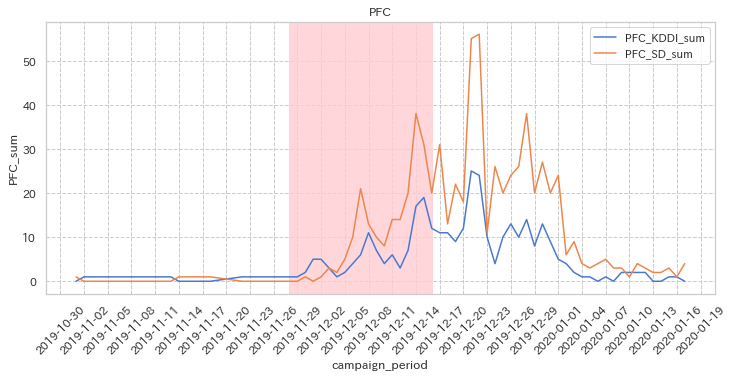

In [69]:
fig, ax = plt.subplots(figsize=(12, 5))

days = mdates.DayLocator(bymonthday=None, interval=3, tz=None)
months = mdates.MonthLocator(bymonth=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]) # 月の設定
years = mdates.YearLocator() # 年の設定
majorFmt = mdates.DateFormatter('%Y-%m-%d') # おっきい軸用フォーマット

plt.plot(df_PFC_KDDI_sum["campaign"],df_PFC_KDDI_sum["PFC_KDDI_sum"])
plt.plot(df_PFC_SD_sum["campaign"],df_PFC_SD_sum["PFC_SD_sum"])

# plt.plot(df_DAU_KDDI_sum["campaign"],df_DAU_KDDI_sum["KDDI_sum"])
# plt.plot(df_DAU_SD_sum["campaign"],df_DAU_SD_sum["SD_sum"])

ax.grid(True)
ax.grid(which='minor', linestyle=':')
ax.xaxis.set_major_formatter(majorFmt)
ax.xaxis.set_major_locator(days) # なくても良い（統一感なくて気持ち悪かったので書いた）
ax.xaxis.set_minor_locator(days)
plt.xticks(rotation=45); # 上に同じく 
plt.xlabel("campaign_period")
plt.ylabel("PFC_sum")
plt.legend()

plt.axvspan('2019-11-28','2019-12-16',alpha=0.8,color="#ffcdd2",label="R/F")

plt.title('PFC')

In [300]:
df_Install_total_SD = df_Install_SD[["campaign", "総計"]]
df_Install_total_SD["SD_cost"] = 15500000
df_Install_total_SD.columns = ["campaign","Total_SD_install_sum", "SD_cost"]
df_Install_total_SD["Total_SD_install_sum"] = df_Install_total_SD["Total_SD_install_sum"].astype(np.int64)
install_sum = df_Install_total_SD["Total_SD_install_sum"].sum()
columns = ["campaign", "Total_SD_install_sum", "SD_cost"]
total_install = pd.DataFrame([['total', install_sum, 15500000]], columns=columns)
df_Install_total_SD = df_Install_total_SD.append(total_install)
df_Install_total_SD["CPI"] = (df_Install_total_SD["SD_cost"])/(df_Install_total_SD["Total_SD_install_sum"])
df_Install_total_SD["CPI"] = df_Install_total_SD["CPI"].astype(np.int64)
df_Install_total_SD.to_csv('../jn/output/df_Install_total_SD.csv', encoding='utf_8_sig')